In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def adf_test2(timeseries):
    dftest = adfuller(timeseries, autolag="BIC")
    return dftest[1:2][0]

def kpss_test2(timeseries):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    return kpsstest[1:2][0]

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('D:/ee-composite/src/sqlserver/data/CCD/Data_ccd.xlsx')
results = pd.DataFrame(columns=['dd0_p1','dd0_p2','dd1_p1', 'dd1_p2', 'dd2_p1', 'dd2_p2'])

for i in range(1,42):
    dd0 = df.query('sn=='+str(i)).loc[:,['year','E']].set_index('year')
    dd1 = dd0.diff(1).dropna()
    dd2 = dd1.diff(1).dropna()
    dd3 = dd2.diff(1).dropna()
    tmp = pd.DataFrame([[adf_test2(dd3), kpss_test2(dd3),adf_test2(dd1),kpss_test2(dd1),adf_test2(dd2),kpss_test2(dd2)]],
            columns=['dd0_p1','dd0_p2','dd1_p1', 'dd1_p2', 'dd2_p1', 'dd2_p2'])
    results=results.append(tmp, ignore_index=True)

print(results)
results.to_excel('ARIMA_ADF_KPSS_P_E2.xlsx', sheet_name='平稳检测')


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

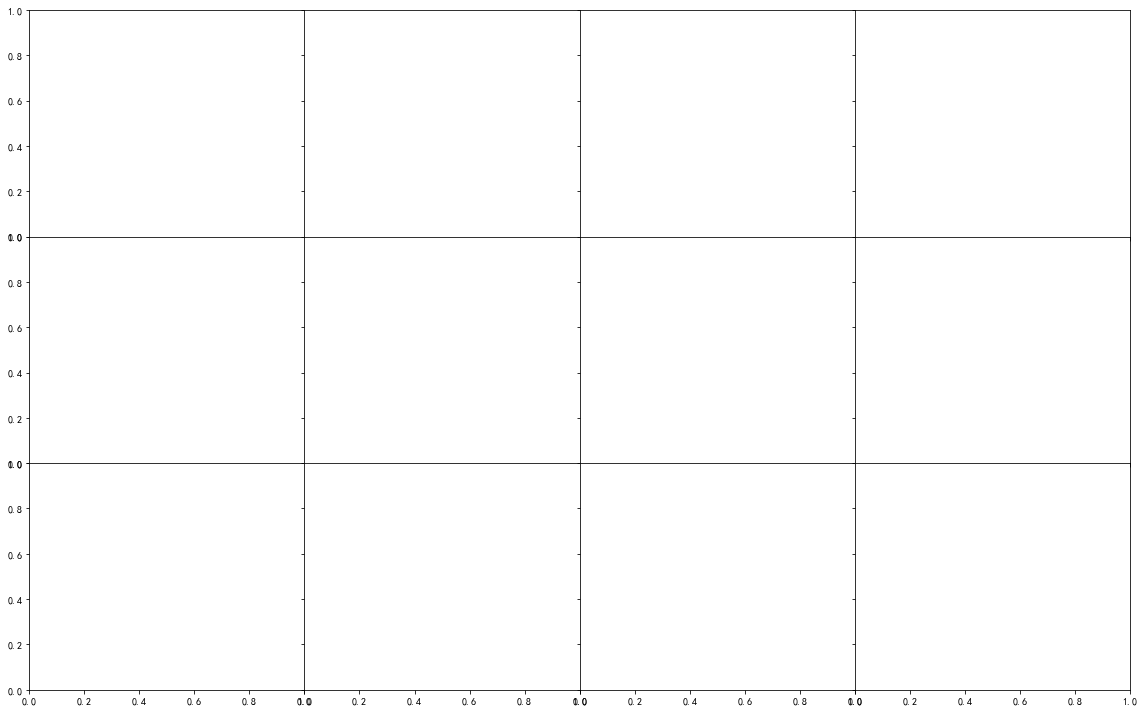

In [2]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

#width，height，列数,行数,中文1英文0,文件序号,子图序号,当前行，当前列
FX,FY,NC,NR,CN,NN,index,row,col,fontx = [16,10,4,3,1,0,0,0,0,9]     #PPT 多图 display 4*3
# FX,FY,NC,NR,CN,NN,index,row,col,fontx = [19,9.5,6,3,1,0,0,0,0,9]    #PPT display 6*3
# FX,FY,NC,NR,CN,NN,index,row,col,fontx = [16,21.33,6,8,0,0,0,0,0,7]    #单图 
EXT,DPI = ['png',300]  # eps svg pdf jpg png
fig,ax =  plt.subplots(figsize=(FX,FY),ncols=NC,nrows=NR,sharex=False,sharey=False)
xxx = np.linspace(0, 1, 100)   #分别代表最小，最大，数量， 生成一个等差数列
indexs = ['01','02','03','04','05','06','07','08','09','10','11','12',
            '13','14','15','16','17','18','19','20','21','22','23','24',
            '25','26','27','28','29','30','31','32','33','34','35','36',
            '37','38','39','40','41','a1','a2','a3','b1','b2','b3','c1']
dates = pd.date_range("1985-1-1", freq="Y", periods=36)
pdindex = pd.Index(sm.tsa.datetools.dates_from_range('1985','2020'))
bestcolumns = ['i','city','p','d','q','mse']
bestdf = pd.DataFrame(columns=bestcolumns)
# print(dates)


# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.4f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.4f' % (best_cfg, best_score))
    return (best_cfg, best_score)

def fig_clear(cn=CN):
    plt.clf()
    global NN,fig,ax
    fontname = 'SimHei' if cn>0 else 'Arial'
    plt.rcParams['font.sans-serif'] = [fontname]
    plt.rcParams['axes.unicode_minus'] = False
    fig,ax =  plt.subplots(figsize=(FX,FY),ncols=NC,nrows=NR,sharex=True,sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    NN +=1

def plot_cell(y,lbl,isEnding=0):
    global index, row, col, ax, bestdf
    index2 = index if index<NC*NR else (index % (NC*NR))
    row = index2 // NC
    col = index2 % NC
    axx = ax[row][col]
    # print(index,index2,row,col)

    # p_values = [0, 1, 2, 4, 6, 8, 10]
    # d_values = range(0, 3)
    # q_values = range(0, 3)
    # best_cfg, best_score = evaluate_models(y.values, p_values, d_values, q_values)
    best_pdqline = best_pdq.query('city=="'+lbl+'"').values[0][3:6]
    p,d,q = best_pdqline
    best_score = best_pdq.at[0,'mse']

    besttmpdata = {'i':index,'city':lbl,'p':p,'d':d,'q':q,'mse':best_score}
    besttmp = pd.DataFrame(data=besttmpdata,index=[0],columns=bestcolumns)
    bestdf = bestdf.append(besttmp,ignore_index=True)

    model = ARIMA(y, order=(p,d,q))  
    fitted = model.fit()

    # fc = fitted.get_prediction(start=36,end=45)
    fc = fitted.get_prediction(start=d,end=45,dynamic=False)
    predicted = fc.predicted_mean
    intervals = fc.conf_int()
    # print(predicted,intervals)

    leftmean = fc.predicted_mean[:15].mean()
    pos1 = 0.65 if leftmean<0.5 else 0.15
    pos2 = 0.58 if leftmean<0.5 else 0.08
    pos0 = 0.08

    axx.tick_params(which='both',direction='in', length=3)
    axx.text(pos0,pos1,r'$ARIMA({:.0f},{:.0f},{:.0f})$'.format(p,d,q),transform = axx.transAxes, fontsize=fontx,zorder=999)
    axx.text(pos0,pos2,r'$MSE={:.4f}$'.format(best_score),transform = axx.transAxes, fontsize=fontx,zorder=999)
    axx.text(0.97,0.965, indexs[index], fontsize='12',fontweight='bold',
                        horizontalalignment='right',verticalalignment='top',
                        transform = axx.transAxes,backgroundcolor='lightgray',
                        fontfamily='sans-serif',zorder=100)
                        
    L1, = axx.plot(predicted.index,predicted,'o-',color='tab:red',label='Prediction',lw=1.5,markeredgecolor ='none',markersize=4)
    L2, = axx.plot(y.index,y,'o-',color='tab:blue',label='Observation('+lbl+')',lw=1,markeredgecolor ='none',markersize=4,alpha=1)
    axx.fill_between(intervals.index[1:], intervals.iloc[1:, 0], intervals.iloc[1:, 1], color='tab:red', alpha=.2)
    axx.legend(handles=[L2, L1], loc="upper left", ncol=1)

    index +=1
    if (row==NR-1 and col==NC-1) or isEnding==1:
        # plt.setp(ax[:, :], xlim=[1984, 2031])
        plt.setp(ax[:, :], ylim=[0, 1])
        plt.setp(ax[-1, :], xlabel='Year')
        plt.setp(ax[:, 0], ylabel='EEQ')
        plt.savefig(fname="year-E-"+str(DPI)+"-"+str(NN)+'.'+EXT,format=EXT, dpi=DPI,pad_inches=0,transparent=True,facecolor='w')
        fig_clear(CN)


## prepare data
df = pd.read_excel('D:/ee-composite/src/sqlserver/data/CCD/Data_ccd.xlsx')
best_pdq = pd.read_excel('D:/ee-composite/src/sqlserver/arima/E_best_p_d_q_mse.xlsx')
fig_clear(CN)

######### Citys
for i in range(1,42,1):
    tmp = df.query('sn=='+str(i)).set_index(pdindex)
    # print(tmp)
    lbl = tmp.iat[0,4] if CN>0 else tmp.iat[0,3]
    plot_cell(tmp['E'],lbl)

######### Provinces
for i,item in enumerate(['Anhui','Jiangsu','Zhejiang']):
    tmp = df.query('province=="'+ item +'"').groupby(by='year').mean().set_index(pdindex)
    lbl = item
    plot_cell(tmp['E'],lbl)
    
######### City types   
for i,item in enumerate(['Magecity','Super city','Large city']):
    tmp = df.query('classid=='+str(i+1)).groupby(by='year').mean().set_index(pdindex)
    plot_cell(tmp['E'],item)

######### study area
tmp = df.groupby(by='year').mean().set_index(pdindex)
plot_cell(tmp['E'],'Study Area',isEnding=1)

# bestdf.to_excel('E_best_p_d_q_mse.xlsx', sheet_name='best')